/opt/conda/lib/python3.9/site-packages/rqalpha/mod/rqalpha_mod_sys_analyser/plot.py:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


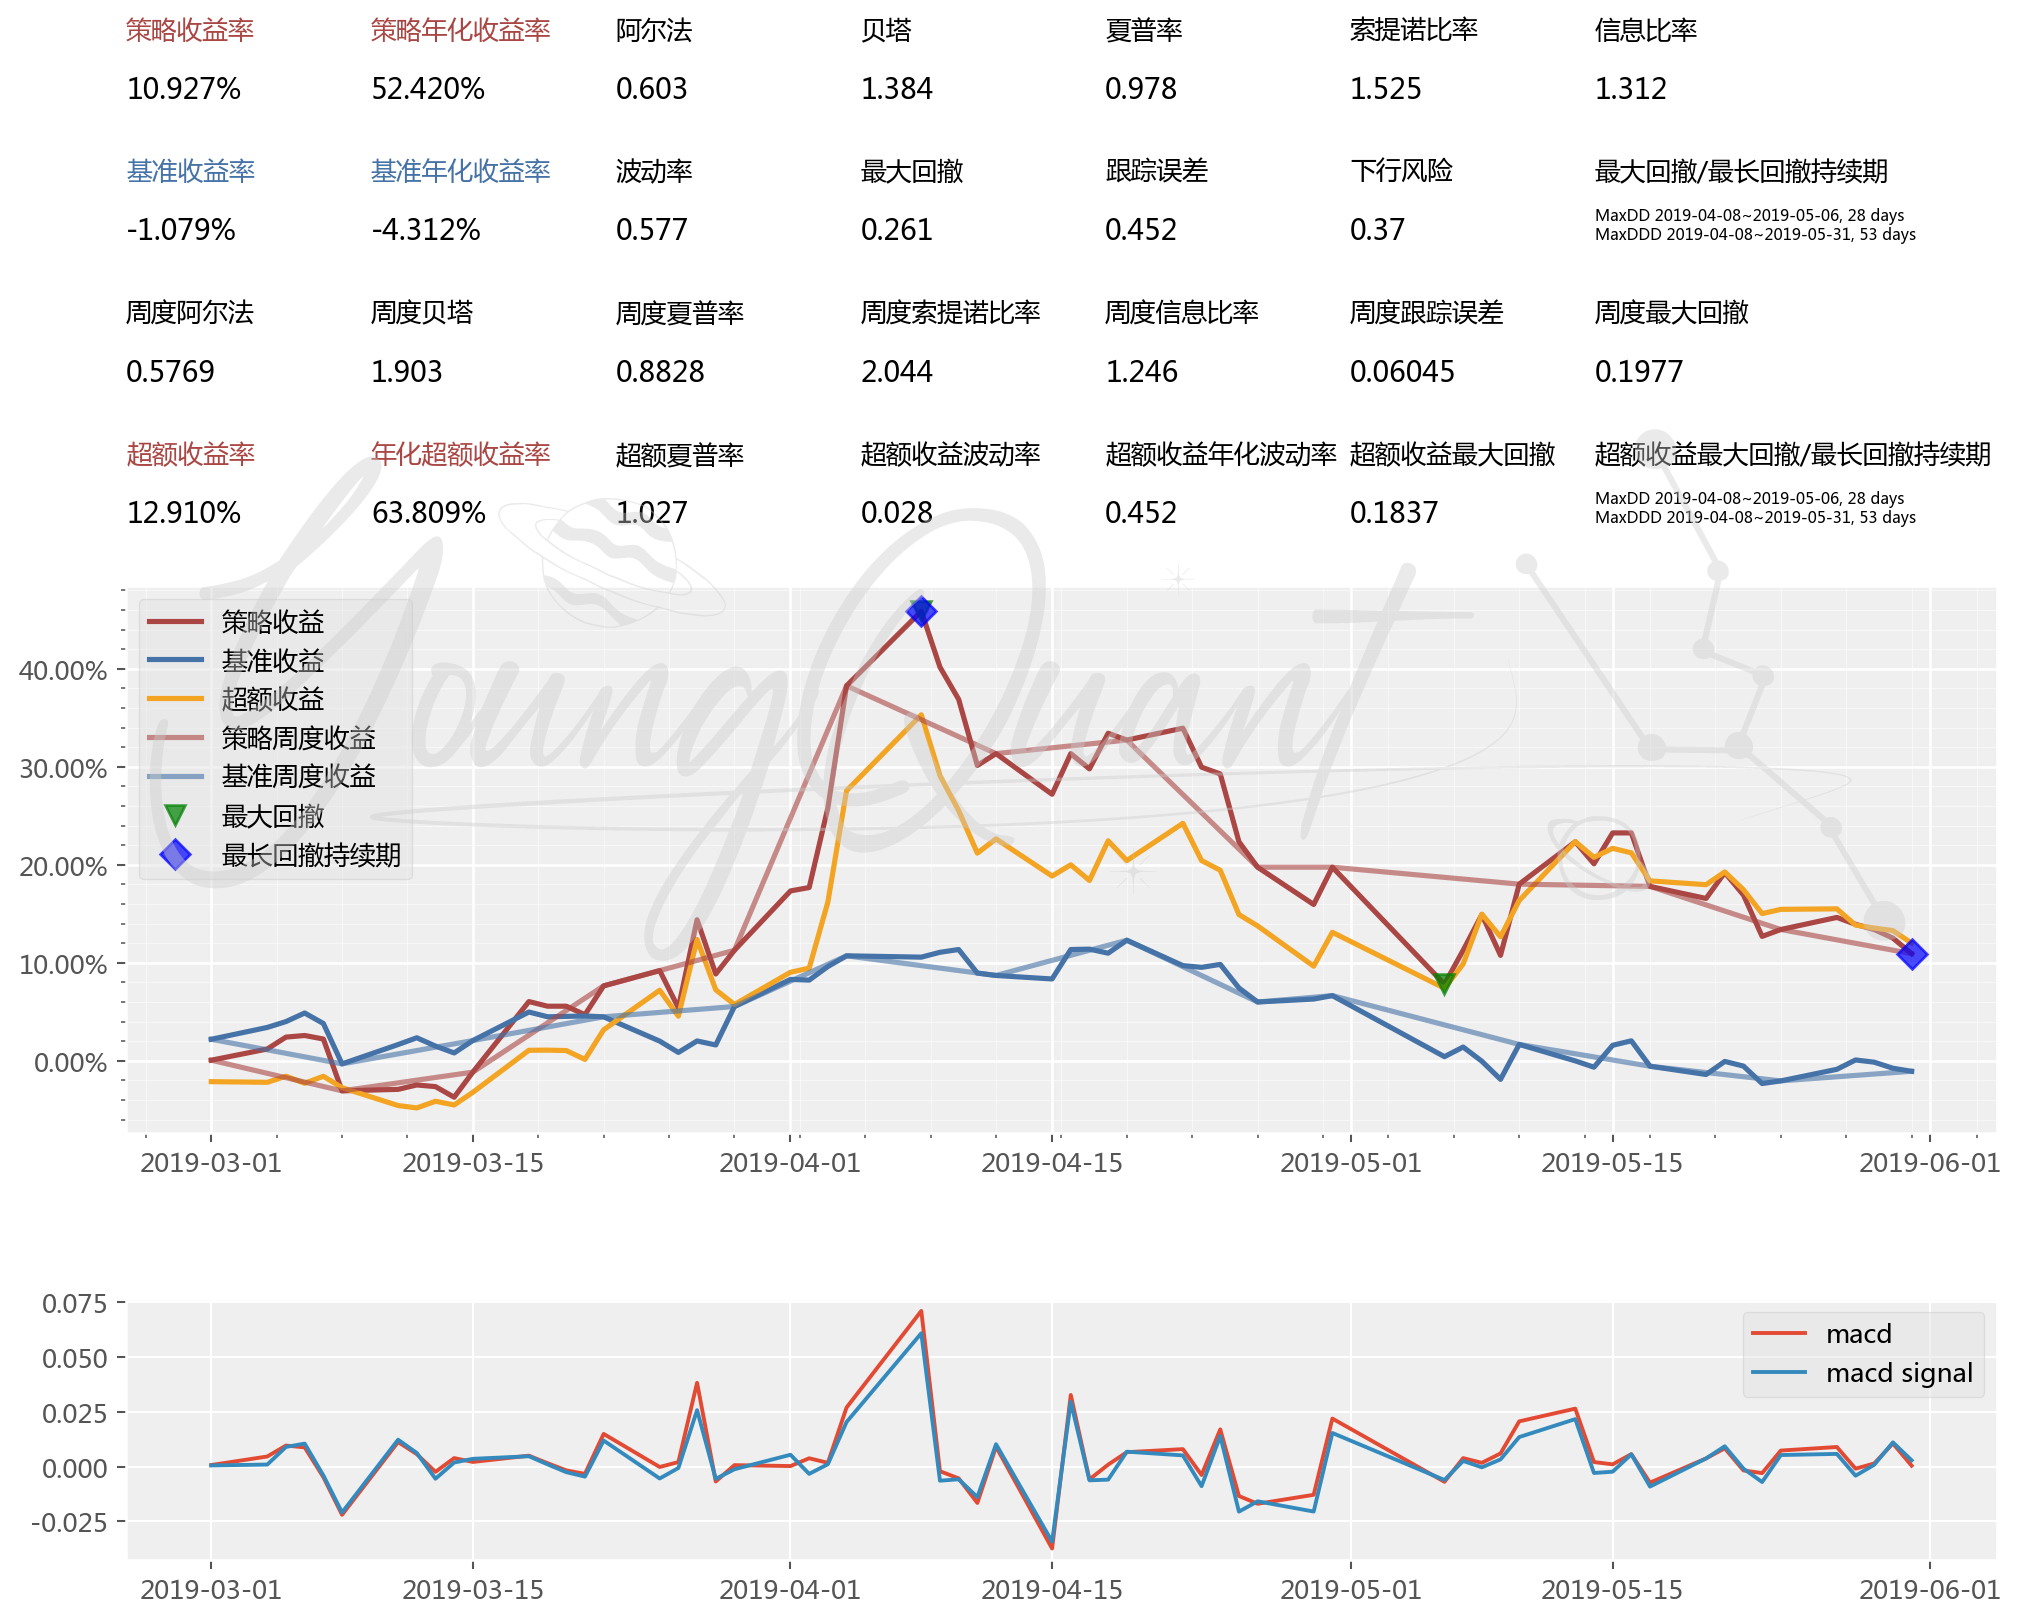

{'sys_analyser': {'summary': {'strategy_name': 'strategy', 'start_date': '2019-03-01', 'end_date': '2019-05-31', 'strategy_file': 'strategy.py', 'run_type': 'BACKTEST', 'STOCK': 100000.0, 'alpha': 0.603, 'beta': 1.384, 'sharpe': 0.978, 'excess_sharpe': 1.027, 'information_ratio': 1.312, 'downside_risk': 0.37, 'tracking_error': 0.452, 'sortino': 1.525, 'volatility': 0.577, 'excess_volatility': 0.028, 'excess_annual_volatility': 0.452, 'max_drawdown': 0.261, 'excess_max_drawdown': 0.1837, 'excess_returns': 0.129103, 'excess_annual_returns': 0.638088, 'total_value': 110927.0942, 'cash': 223.0942, 'total_returns': 0.109271, 'annualized_returns': 0.5242, 'unit_net_value': 1.1093, 'units': 100000.0, 'benchmark_total_returns': -0.010787, 'benchmark_annualized_returns': -0.043124, 'weekly_alpha': 0.576918973095237, 'weekly_beta': 1.9032687865037072, 'weekly_sharpe': 0.8828297699998326, 'weekly_sortino': 2.043664312737137, 'weekly_information_ratio': 1.2460965961247585, 'weekly_tracking_error':

In [23]:
from rqalpha.api import *
from rqalpha import run_func
import numpy as np
import pandas as pd
import talib

p_price = 0
# 在这个方法中编写任何的初始化逻辑。
# context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "002461.XSHE"

    # 使用MACD需要设置长短均线和macd平均线的参数
    context.SHORTPERIOD = 12
    context.LONGPERIOD = 26
    context.SMOOTHPERIOD = 9
    context.OBSERVATION = 100


# 你选择的证券的数据更新将会触发此段逻辑
# 例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 读取历史数据，使用sma方式计算均线准确度和数据长度无关
    # 但是在使用ema方式计算均线时建议将历史数据窗口适当放大，结果会更加准确
    global p_price
    prices = history_bars(context.s1, context.OBSERVATION,'1m','close')
    prices = np.hstack(prices)
    #print(prices)

    # 用Talib计算MACD取值，得到三个时间序列数组，分别为macd, signal 和 hist
    macd, signal, hist = talib.MACD(prices, context.SHORTPERIOD,
                                    context.LONGPERIOD, context.SMOOTHPERIOD)

    plot("macd", macd[-1])
    plot("macd signal", signal[-1])

    # macd 是长短均线的差值，signal是macd的均线，使用macd策略有几种不同的方法，我们这里采用macd线突破signal线的判断方法

    # 如果macd从上往下跌破macd_signal
    # 34的意思：macd前34个值是nan?暂时没有去了解为什么
    if macd[-1] - signal[-1] < 0 and macd[-2] - signal[-2] > 0:
        # 获取当前投资组合中股票的仓位
        curPosition = get_position(context.s1).quantity
        p_price = get_position(context.s1,POSITION_DIRECTION.LONG).avg_price
        #进行清仓
        if curPosition > 0:
            if p_price > prices[-1]:
                if np.mean(np.gradient(macd)[34:]) < 0:
                    order_percent(context.s1, -0.5)
                else:
                    order_percent(context.s1, -0.25)
            else:
                #设置止损线,出现卖出信号且亏损5%，强制平仓
                if prices[-1] < 0.95 * p_price:
                    order_target_value(context.s1, 0)
            #print('sell',prices[-1])

    # 如果短均线从下往上突破长均线，为入场信号
    if macd[-1] - signal[-1] > 0 and macd[-2] - signal[-2] < 0 and np.mean(np.gradient(macd)[34:]) > 0 and np.mean(np.gradient(signal)[34:]) > 0:
            lastday_close = history_bars(context.s1, 1,'1d','close')
            lastday_close = lastday_close[0]
            # 开仓入股
            if np.mean(np.gradient(prices)[34:]) > 0 and lastday_close > prices[-1]:
                order_percent(context.s1, 0.5)
            elif np.mean(np.gradient(prices)[34:]) < 0:
                order_percent(context.s1, 0.5)
                #print('buy',prices[-1])

'''
    get_position(context.s1,POSITION_DIRECTION.LONG).avg_price
    #设置止损线,盈亏损2%强制平仓   
    if prices[-1] < 0.98 * p_price:
        order_target_value(context.s1, 0)
'''

        
config = {
  "base": {
    "start_date": "2019-03-01 09:00:00",
    "end_date": "2019-06-01 15:03:00",
    "frequency": "1m",
      "benchmark": "000300.XSHG",
    "accounts": {
        "stock": 100000
    }
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "mongodb": {
      "enabled": True,
      "ts_code": "002461.SZ"
    },
    "sys_analyser": {
            "benchmark": "000300.XSHG",
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
report=run_func(init=init, handle_bar=handle_bar, config=config)
df = pd.DataFrame(report)
print(report)
df.to_csv('0001.csv')